<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Definições-Iniciais" data-toc-modified-id="Definições-Iniciais-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Definições Iniciais</a></span></li><li><span><a href="#Primeiro-Contato" data-toc-modified-id="Primeiro-Contato-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Primeiro Contato</a></span><ul class="toc-item"><li><span><a href="#Leitura-dos-Sinais-de-Áudio" data-toc-modified-id="Leitura-dos-Sinais-de-Áudio-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Leitura dos Sinais de Áudio</a></span></li><li><span><a href="#Visualizando-os-Sinais-de-Onda" data-toc-modified-id="Visualizando-os-Sinais-de-Onda-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Visualizando os Sinais de Onda</a></span></li><li><span><a href="#Transformada-de-Fourier" data-toc-modified-id="Transformada-de-Fourier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Transformada de Fourier</a></span></li><li><span><a href="#Espectrogramas" data-toc-modified-id="Espectrogramas-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Espectrogramas</a></span></li></ul></li></ul></div>

Este notebook tem por objetivo providenciar o primeiro contato do desenvolvedor com materiais relacionado a áudios, sejam estes descritos por bibliotecas python (`librosa`, `PySoundFile`) ou mesmo amostras de áudios gravadas para análises exploratórias. O desenvolvimento do código a seguir faz parte de um trabalho de graduação do curso de Engenharia de Informação oferecido pela Universidade Federal da ABC. 

A grande motivação do projeto gira em torno da análise, entendimento, extração de features e treinamento de modelos capazes de reconhecer o interlocutor em sinais de áudio recebidos. Para tal, pretende-se utilizar ferramentas python para o entendimento sonoro como um todo, além de frameworks de Deep Learning (`tensorflow`, `keras`) para a construção de Redes Neurais Artificais capazes de realizar o trabalho de reconhecimento ou _speaker verification_.

<img src="https://ondetemcoronavirus.com.br/wp-content/uploads/2020/09/logo-ufabc-1-1.png" alt="ufabc logo">

> 📌**Nota**: os sinais de áudio a serem lidos neste documento fazem parte de um teste inicial onde três diferentes interlocutores pronunciaram uma mesma frase específica para futuras análises comparativas. Assim, as amostras são compostas por:
* _Interlocutor 01_: áudio de 2 segundos e com 5,5kB
* _Interlocutor 02_: áudio de 1 segundo e com 3,5kB
* _Interlocutor 03_: áudio de 3 segundos e com 6,7kB

Todos os áudios possuem um _sample rate_ de 16kHz

<div class="alert alert-block alert-info">
<b>Observação:</b> As amostras de áudio utilizadas neste notebook foram gravadas via WhatsApp através de um equipamento celular <code>moto g(6) plus</code> com Android versão 9 (PPW29.116-16-29). As gravações foram realizadas e enviadas a um contato específico na plataforma para posteriormente serem baixadas em formato .ogg no sistema operacional de trabalho.
</div>

___
`[IDEIA 01]` para desenvolvimento de rotina (script) no whatsapp para realizar o download rotineiro de arquivos de um determinado grupo. Dessa forma, seria possível:
1. Criar um grupo no whatsapp específico para cada interlocutor;
2. Combinar com os interlocutores que enviem mensagens de áudio rotineiramente para grupos individuais
3. Rodar (ou deixar rodando) script que realiza o download destes sinais

`[IDEIA 02]` criar uma função pra ler sinais de áudio e transformar os dados em um pandas DataFrame. A ideia é gerar uma base de dados com as principais informações do áudio em formato tabular.

`[IDEIA 03]` testar simulações em vida real, analisando erros de reconhecimento com outras pessoas pronunciando frases ou mesmo possíveis erros em pessoas não habilitadas utilizando gravações de pessoas habilitadas pra tentar burlar o sistema.
___

# Definições Iniciais

Antes de iniciar o primeiro contato, é importante importar algumas bibliotecas python para auxiliar a leitura e o entendimento dos sinais sonoros gravados. Adicionalmente, serão definidas algumas variáveis de projeto para referenciar os arquivos no diretório do projeto

In [1]:
# Importando bibliotecas
import librosa
import librosa.display as ld
from IPython.display import Audio

import os
import numpy as np
import scipy

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

# Definindo variáveis
DATA_PATH = '../data/samples'
print(f'Arquivos disponíveis para análise:\n\n{os.listdir(DATA_PATH)}')

Arquivos disponíveis para análise:

['interlocutor03.ogg', 'interlocutor02.ogg', 'interlocutor01.ogg']


# Primeiro Contato

Definidas as bibliotecas e as variáveis iniciais do projeto, é possível investigar algumas propriedades dos áudios gravados. Como primeira tarefa, é possível utilizar o módulo `display` da biblioteca `IPython`.

In [2]:
# Interlocutor 01
Audio(os.path.join(DATA_PATH, 'interlocutor01.ogg'))

In [3]:
# Interlocutor 02
Audio(os.path.join(DATA_PATH, 'interlocutor02.ogg'))

In [4]:
# Interlocutor 03
Audio(os.path.join(DATA_PATH, 'interlocutor03.ogg'))

> 📌 **Nota**: analisando os áudios gravados, é possível pontuar que os três interlocutores possuem características vocais diferentes. Na prática, é válido pontuar:
* _Interlocutor 01_: gênero masculino entre 25 e 30 anos de idade;
* _Interlocutor 02_: gênero masculino entre 60 e 65 anos de idade;
* _Interlocutor 03_: gênero feminino entre 55 e 60 anos de idade.

## Leitura dos Sinais de Áudio

Após uitlizar o ferramental específico do jupyter notebook para mostrar os áudios gravados e ouvir, de fato, os elementos que o compõe, é possível agora realizar a leitura definitiva destes sinais de modo a propor análises mais aprofundadas sobra sua composição. Para esta etapa, será utilizada a biblioteca [librosa](https://librosa.org/doc/latest/index.html), um instrumento poderoso para análise de áudio.

<div class="alert alert-block alert-info">
    <b>Observação:</b> Nas primeiras tentativas de leitura dos arquivos <code>.ogg</code> de áudio, a exceção <code>NoBackendError</code> estava sendo retornada, impossibilitando assim a leitura. Após pesquisas em sites e fóruns, descobriu-se a necessidade de instalar, em sistemas Ubuntu, o pacote <code>ffmpeg</code> para que a leitura dos áudios pudesse ser feita corretamente. O <a href=https://github.com/librosa/librosa/issues/219>link</a> de referência recomenda rodar o comando <code>sudo apt install ffmpeg</code> para resolução do problema.
</div>

In [5]:
# Lendo sinal do interlocutor 01
y_i1, sr_i1 = librosa.load(os.path.join(DATA_PATH, 'interlocutor01.ogg'))

print(f'Sinal y: \n{y_i1}')
print(f'\nDimensões de y: {y_i1.shape}')
print(f'\nSample Rate: {sr_i1}Hz')
print(f'\nDuração do áudio: {round(y_i1.shape[0]/sr_i1, 2)}s')

Sinal y: 
[-1.17150755e-07  1.63246639e-07 -2.13971731e-07 ... -5.37504489e-03
 -5.36875986e-03 -5.83680719e-03]

Dimensões de y: (56889,)

Sample Rate: 22050Hz

Duração do áudio: 2.58s


A aplicação do método `load()` da biblioteca `librosa` retorna os seguintes parâmetros:
* **Sinal de áudio**: representado pela variável `y`, indica a sequência de vibrações em diferentes magnitudes de pressão. O elemento `y[t]` indica a amplitude do sinal em determinado instante t.
* **Taxa de amostragem**: representado pela variável `sr`, indica o número de amostras por segundo do sinal sonoro.

Analisando os resultados, a dimensão da variável `y` acima, dada pelo array unidimensional `(56889,)`, indica que o sinal é composto por 56889 amostras em um único canal (Mono) ao longo de todo o áudio. Intuitivamente, ao dividir a quantidade de amostras pela taxa de amostragem por segundo, é possível obter a duração, em segundos do áudio. Para o exemplo acima:

$$T = \frac{\text{Quantidade de Amostras}}{\text{Amostras por Segundo}}=\frac{56889 \text{ amostras}}{22050Hz}=2.58s$$

> 📌 **Nota**: Apesar de ter informado, na primeira descrição dos áudios, que a taxa de amostragem era de 16kHz, vimos que, na verdade, a taxa de amostragem (ou sample rate) dos sinais é de 22050Hz. Isso se dá pois, de acordo com a [documentação](https://librosa.org/doc/latest/tutorial.html) da biblioteca `librosa`, por padrão, todos os sinais lidos são convertidos pra uma taxa de amostragem de 22050Hz durante a leitura.

<div class="alert alert-block alert-info">
    <b>Observação:</b> Em complemento, segundo artigo do site <a href=https://dropsofai.com/sound-wave-basics-every-data-scientist-must-know-before-starting-analysis-on-audio-data/>Drops of AI</a>, o ouvido humano tem um range de interpretação que varia entre 20 e 20.000Hz e, dessa forma, não há nenhum ponto de captura de frequências que supere os 20kHz. Portando, de acordo com o teorema de Nyquist para taxas de amostragem, se amostrarmos os sinais em frequências maiores que 40kHz, nenhuma informação será perdida entre aquilo que está dentro do intervalo de escuta do ouvido humano. Por esse motivo, muitos sinais de áudio possuem uma taxa de 44.1kHz (22050 * 2).
</div>

Para validar o entendimento deste primeiro contato com sinais sonoros, vamos utilizar um exemplo de áudio disponibilizado pela própria biblioteca `librosa`. Ainda considerando apenas os indicadores acima retornados, vejamos a diferença para um áudio mais longo.

In [6]:
# Comparando com exemplo pronto
example = librosa.util.example_audio_file()
Audio(example)

In [7]:
# Lendo sinal do áudio exemplo
y_ex, sr_ex = librosa.load(example)

print(f'Sinal y: \n{y_ex}')
print(f'\nDimensões de y: {y_ex.shape}')
print(f'\nSample Rate: {sr_ex}Hz')
print(f'\nDuração do áudio: {round(y_ex.shape[0]/sr_ex, 2)}s')

Sinal y: 
[0. 0. 0. ... 0. 0. 0.]

Dimensões de y: (1355168,)

Sample Rate: 22050Hz

Duração do áudio: 61.46s


Em comparação, o áudio de exemplo demorou um pouco para ser lido, visto que realmente possui um número maior de amostras e, por consequência, um tempo maior de duração (uma vez que a taxa de amostragem de ambos é igual a 22050Hz). Apenas como curiosidade, é possível perceber que o áudio de exemplo inicia com amplitudes em zero e também finaliza com amplitudes no mesmo patamar, indicando que, apesar de sutil, o áudio inicia e finaliza em total silêncio.

In [8]:
# Lendo os demais áudios disponíveis
y_i2, sr_i2 = librosa.load(os.path.join(DATA_PATH, 'interlocutor02.ogg'))
y_i3, sr_i3 = librosa.load(os.path.join(DATA_PATH, 'interlocutor03.ogg'))

## Visualizando os Sinais de Onda

Uma vez lidos os sinais, é possível utilizar a funcionalidade de display da onda sonora para visualizar cada um dos áudios disponíveis. Utilizando as amplitudades e a taxa de amostragem de cada sinal, o método [`display.waveplot()`](https://librosa.org/doc/main/generated/librosa.display.waveplot.html) da biblioteca `librosa` é o responsável por propor essa visualização gráfica dos sinais.

<div class="alert alert-block alert-info">
<b>Observação:</b> Em um primeiro momento, ao tentar executar o método <code>librosa.display.waveplot()</code> foi retornada a exception <code>AttributeError: module 'librosa' has no attribute 'display'</code>. Isso se deu pelo necessidade de importação explícita do referido módulo da biblioteca. O comando <code>import librosa.display</code> resolve o problema. Link do <a href=https://librosa.org/doc/main/troubleshooting.html>troubleshooting</a>.
</div>

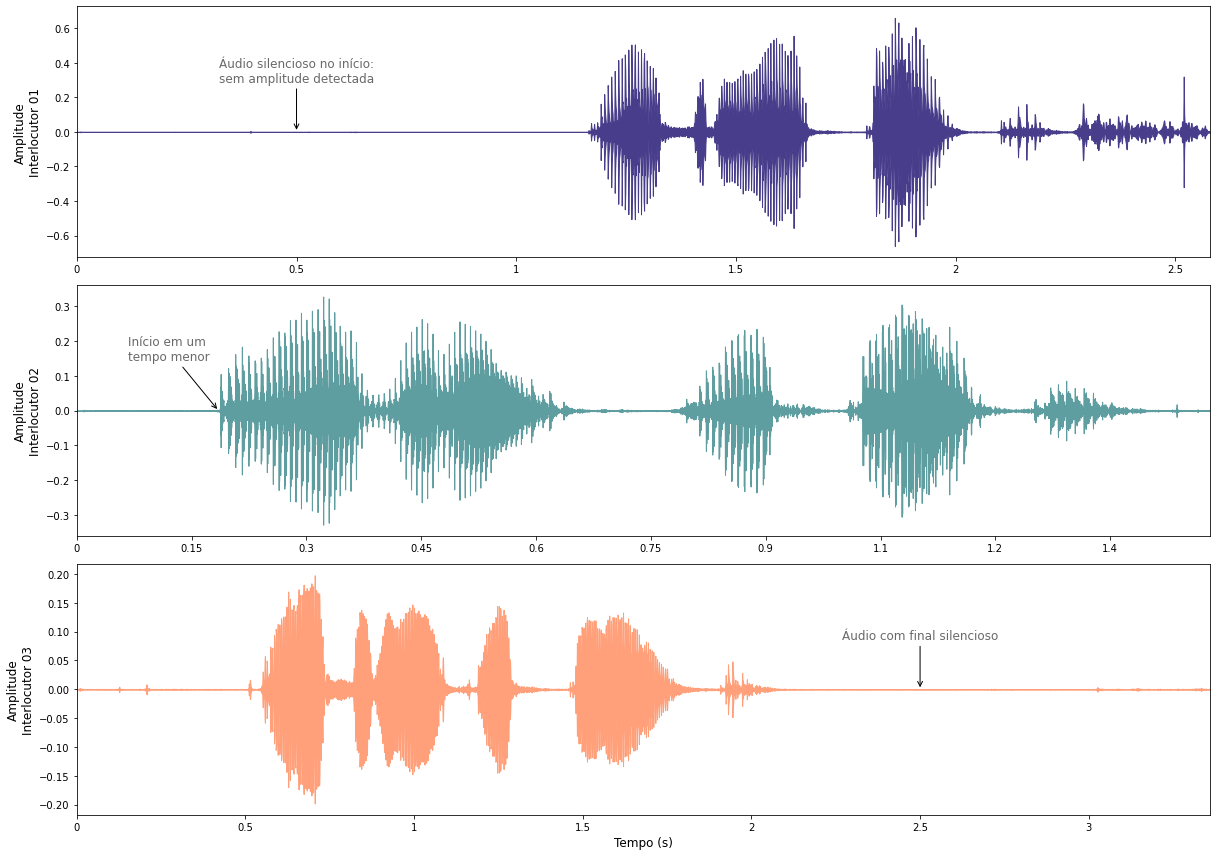

In [9]:
# Definindo variáveis de plotagem
audio_amps = [y_i1, y_i2, y_i3]
audio_srs = [sr_i1, sr_i2, sr_i3]
signal_colors = ['darkslateblue', 'cadetblue', 'lightsalmon']

# Definindo figura de plotagem
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(17, 4*len(audio_amps)))

# Iterando sobre sinais
i = 0
for y, sr in zip(audio_amps, audio_srs):
    ax = axs[i]
    ld.waveplot(y=y, sr=sr, color=signal_colors[i], ax=ax)
    i += 1
    
    # Customizando plotagens
    #ax.set_title(f'Visualização do Sinal de Áudio - Interlocutor 0{i}', size=14)
    ax.set_xlabel('')
    ax.set_ylabel(f'Amplitude\nInterlocutor 0{i}', size=12)
ax.set_xlabel('Tempo (s)', size=12)
    
# Realizando anotações na plotagem
axs[0].annotate(f'Áudio silencioso no início:\nsem amplitude detectada', (0.5, 0.0), xytext=(0,50), 
             textcoords='offset points', size=12, #bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='->', fc='w'), color='dimgrey', ha='center')
axs[1].annotate(f'Início em um \ntempo menor', (0.185, 0.0), xytext=(-50,50), 
             textcoords='offset points', size=12, #bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='->', fc='w'), color='dimgrey', ha='center')
axs[2].annotate(f'Áudio com final silencioso', (2.5, 0.0), xytext=(0,50), 
             textcoords='offset points', size=12, #bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='->', fc='w'), color='dimgrey', ha='center')   
plt.tight_layout()

Neste cenário de visualização dos áudios, é importante destacar algumas particularidades de cada sinal como, por exemplo, o tempo de duração, a frequência e as amplitudes obtidas em cada espaço de tempo. O eixo x, relacionado a dimensão de tempo dos sinais, não está sincronizado, porém é possível ter uma ideia de sobreposição dos sinais observando os espaços de tempo relacionados a cada amplitude.

No gráfico abaixo, os sinais são plotados em um mesmo eixo, sendo assim possível analisar as principais diferenças citadas acima de forma visual. Adicionalmente, será plotado também o sinal de áudio lido como exemplo diretamente da biblioteca librosa.

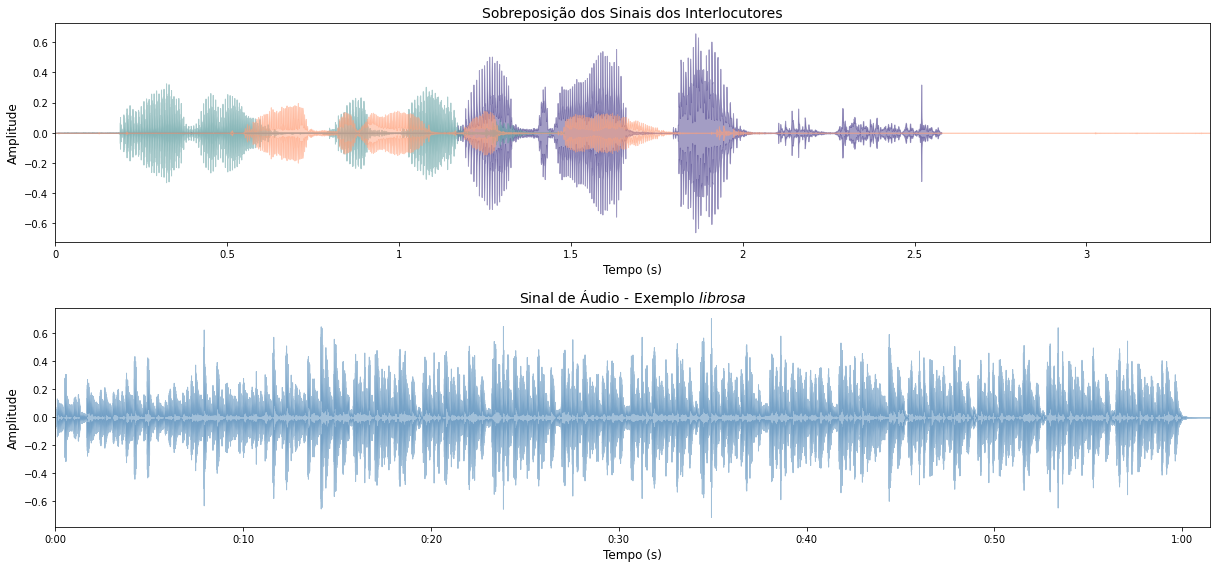

In [10]:
# Plotando os três sinais em uma única figure
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(17, 8))
ld.waveplot(y=y_i1, sr=sr_i1, color='darkslateblue', alpha=.5, ax=axs[0])
ld.waveplot(y=y_i2, sr=sr_i2, color='cadetblue', alpha=.5, ax=axs[0])
ld.waveplot(y=y_i3, sr=sr_i3, color='lightsalmon', alpha=.5, ax=axs[0])

# Plotando sinal de áudio de exemplo
librosa.display.waveplot(y=y_ex, sr=sr_ex, color='steelblue', ax=axs[1], alpha=.5)

# Customizando plotagem
for ax in axs:
    ax.set_ylabel('Amplitude', size=12)
    ax.set_xlabel('Tempo (s)', size=12)
axs[0].set_title('Sobreposição dos Sinais dos Interlocutores', size=14)
axs[1].set_title('Sinal de Áudio - Exemplo $librosa$', size=14)

plt.tight_layout()
plt.show()

Existem ainda diversas possibilidades de transformações nos sinais de áudio lidos. Nas próximas etapas, vamos aplicar essas transformações de modo a extrair informações relevantes dos sinais para que, no decorrer da análise, seja possível entender conceitos técnicos e teóricos sobre o assunto.

## Transformada de Fourier

A biblioteca `librosa` traz uma série de funções prontas para aplicar transformações em sinais de áudios lidos. A transformada de Fourier é uma função que decompõe um sinal de entrada, no domínio do tempo, em frequências distintas. Em outras palavras, é a representação de um sinal temporal no domínio da frequência.

Na prática, a transformada de Fourier pode ser entendida como um cálculo que permite analisar de forma mais detalhada as frequências presentes em um determinado sinal. O entendimento desse conceito pode ser obtido através de uma análise nos sinais temporais plotados na sessão anterior: em cada um deles, tem-se a relação de amplitude para cada instante de tempo do áudio. Independente da quantidade de frequências distintas que compõe este sinal e, sendo um sinal de áudio, espera-se que este seja um número elevado, a análise temporal não traz uma ideia clara de intensidades de cada uma das frequências presentes no sinal, sendo impossível realizar essa identificação e, por consequência, análises mais específicas.

Ao aplicar a transformada de Fourier, é possível identificar as frequências que compõe um dado sinal variante no tempo e, além disso, analisar suas intensidades, permitindo assim conclusões mais detalhadas sobre as características do sinal de entrada. Nos blocos de código a seguir, todo o conceito dessa migração entre domínios será ilustrado através de funções e sinais gerados artificalmente de forma teórica. Na sequência, serão aplicadas as transformadas nos sinais reais de áudio lidos.

Algumas definições importantes:

* **FT**: _Fourier Transform_ - considera a Transformação de Fourier padrão em um sinal contínuo de input;
* **DFT**: _Discrete Fourier Transform_ - considera a Transformação de Fourier em um sinal discreto fornecido como input;
* **FFT**: _Fast Fourier Transform_ - algoritmo que aplica a DFT para conversão de um sinal discreto.

In [11]:
# Importando bibliotecas adicionais
import scipy

# Definindo função para gerar sinais
def gera_sinal(freq, samples, amp=1):
    """
    Função responsável por gerar sinais a partir de um número fixo de amostras
    
    Parâmetros
    ----------
    :param freq: frequência do sinal a ser gerado [type: int]
    :param samples: número de amostras geradas [type: int]
    :param amp: amplitude do sinal a ser gerado [type: float]
    
    Retorno
    -------
    :return x: coordenadas do eixo x (tempo) da função [type: float]
    :return y: cordenadas do eixo y (amplitude) da função [type: float]
    """
    
    # Gerando valores de x e y
    x = np.arange(samples)
    y = amp * np.sin(2 * np.pi * freq * (x / samples))
    
    return x, y

# Defindo função para calcular fft dos sinais
def calcula_fft(signal, samples):
    """
    Função responsável por calcular a fft de um sinal de entrada
    
    Parâmetros
    ----------
    :param signal: sinal de entrada em formato de séries temporais [type: list/array]
    :param samples: número de amostras do sinal de entrada [type: int]
    
    Retorno
    -------
    :return xf: lista de frequências (coordenada x da plotagem) [type: list/array]
    :return yf: intensidades das frequências (coordenada y da plotagem) [type: list/array]
    """
    
    # Calculando elementos e período
    yf = scipy.fft.fft(signal)
    xf = scipy.fft.fftfreq(samples, 1/samples)
    
    return xf, yf

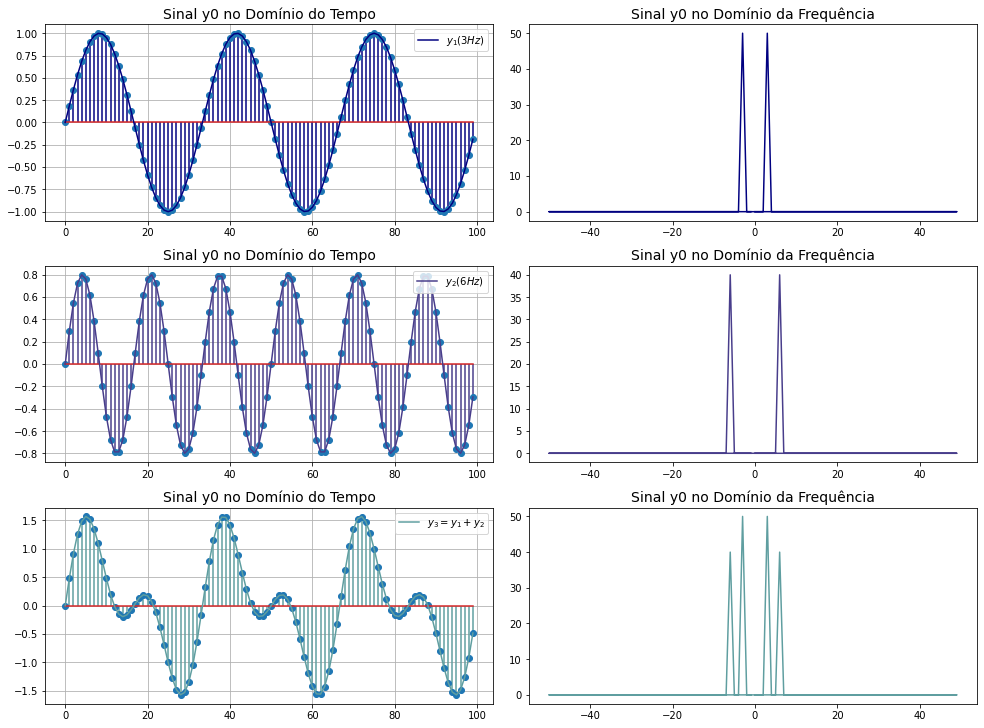

In [12]:
# Definindo parâmetros dos sinais
f1 = 3
a1 = 1
f2 = 6
a2 = .8
samples = 100
colors = ['navy', 'darkslateblue', 'cadetblue']

# Definindo figura de plotagem e eixos
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

# Gerando e plotando sinal y1 e sua fft
x, y1 = gera_sinal(freq=f1, samples=samples, amp=a1)
xf1, yf1 = calcula_fft(signal=y1, samples=samples)
ax1.stem(x, y1, colors[0])
ax1.plot(x, y1, color=colors[0], label=f'$y_1({f1}Hz)$')
ax2.plot(xf1, np.abs(yf1), color=colors[0])
ax1.set_title(f'')

# Gerando e plotando sinal y2 e sua fft
_, y2 = gera_sinal(freq=f2, samples=samples, amp=a2)
xf2, yf2 = calcula_fft(signal=y2, samples=samples)
ax3.stem(x, y2, colors[1])
ax3.plot(x, y2, color=colors[1], label=f'$y_2({f2}Hz)$')
ax4.plot(xf2, np.abs(yf2), color=colors[1])

# Gerando e plotando sinal y2 e sua fft
y3 = y1 + y2
xf3, yf3 = calcula_fft(signal=y3, samples=samples)
ax5.stem(x, y3, colors[2])
ax5.plot(x, y3, color=colors[2], label=f'$y_3=y_1+y_2$')
ax6.plot(xf3, np.abs(yf3), color=colors[2])

for ax in ax1, ax3, ax5:
    i = 0
    ax.grid(True)
    ax.legend(loc='upper right')
    ax.set_title(f'Sinal y{i} no Domínio do Tempo', size=14)
    i += 1
    
for ax in ax2, ax4, ax6:
    i = 0
    ax.set_title(f'Sinal y{i} no Domínio da Frequência', size=14)
    i += 1

Na exemplificação acima, são ilustrados duas ondas senoidais `y1` e `y2` de diferentes frequências `f1` e `f2`. A partir da soma dessas ondas, é gerado o sinal `y3` em uma relação relativamente mais complexa que os sinais individuais. Concebido como a soma de duas ondas de frequências diferentes, o sinal `y3`, em termos matemáticos, pode ser dado como a composição conjunta, em cada instante de tempo, das amplitudes correspondentes aos sinais `y1` e `y2`. Mesmo que ilustrativo, o sinal `y3` é uma pequena amostra do que pode ser encontrado no mundo real em termos de sinais sonoros, uma vez que a própria fala humana é composta por uma junção de diferentes frequências distintas.

Observando o sinal `y3` e realizando uma extrapolação pra casos reais, é possível imaginar uma certa dificuldade em extrair informações relevantes de sinais compostos por diversas frequências, visto que o comportamento ondulatório dos áudios, evidenciado alguns gráficos acima, é extremamente diferente de ondas senoidas teóricas devido ao vasto leque de interferências e combinações no meio. 

Neste ponto da análise, a transformada de Fourier se mostra altamente eficaz: seu grande objetivo é decompor sinais que estejam no domínio do tempo para o domínio da frequência, implicando assim em uma análise mais detalhada sobre cada uma das frequências embutidas em qualquer sinal de entrada, independente de sua complexidade. Em toda a segunda coluna da figura de plotagem acima, é plotada a transformada de Fourier de cada um dos sinais relacionados. Sabendo que a frequência `f1` do sinal `y1` é igual a 3Hz e que a frequência `f2` do sinal `y2` é 6Hz, é possível identificar estes picos nas respectivas plotagens no domínio da frequência. No caso do sinal composto `y3`, não está devidamente claro qual a frequência final do sinal, visto que se trata de uma composição de dois sinais de frequências distintas. Entretando, através da análise no domínio da frequência, é possível identificar, de fato, que o sinal `y3` é composto por duas frequências distintas (3Hz e 6Hz), sendo estas representadas pelos picos obtidos a partir da FFTa FFT (Transformada Rápida de Fourier). Com isso, é possível obter conclusões muito mais assertivas sobre as características de um sinal antes considerado complexo por natureza.

**_Links de referência_**:
* https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520
* https://realpython.com/python-scipy-fft/

___
* **_Cálculo da Transformada de Fourier em Sinais de Áudio_**
___

Após realizar uma análise inicial das motivações por trás da aplicação da Transformada de Fourier, é possível unir tais conceitos a algumas ferramentas contidas na biblioteca `librosa` para análises avançadas no domínio da frequência. Vimos, nos gráficos acima, a importância em realizar este tipo de análise para a extração de informações adicionais em sinais complexos. A voz humana, tendo em sua natureza a compressão e descompressão de um meio (ar), é concebida a partir de uma série de frequências distintas se propagando em um meio, diferente de uma análise ilustrativa de 2 ou 3 frequências distintas.

Dessa forma, as transformações abaixo visam propor uma visão real da Transformada de Fourier nos sinais de áudio gravados e utilizados como exemplo.

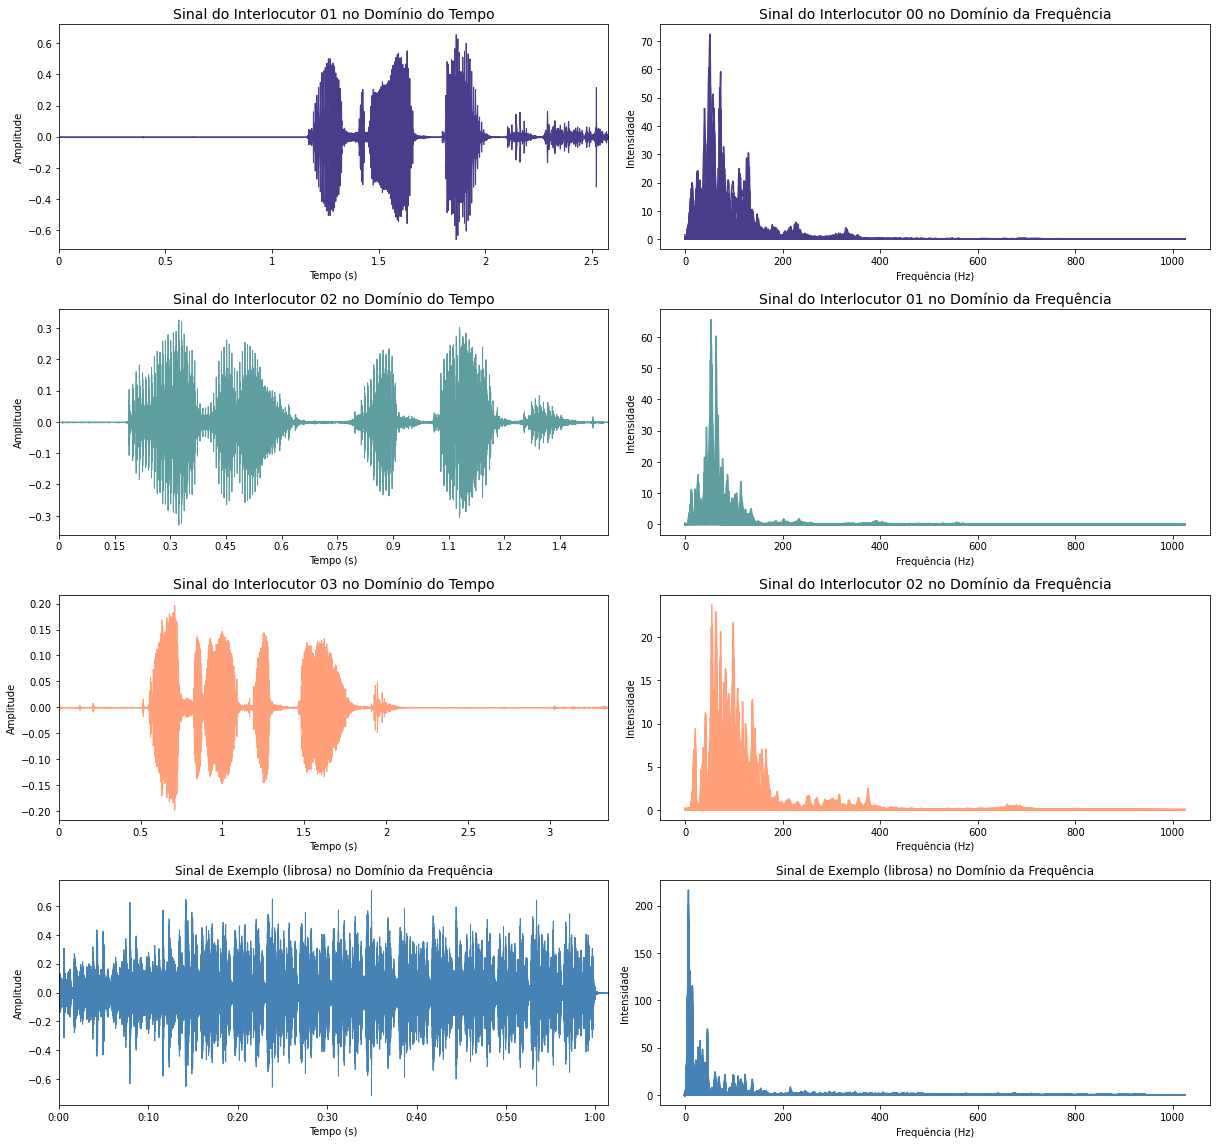

In [13]:
# Definindo parâmetros de plotagem
audios = [y_i1, y_i2, y_i3, y_ex]
sample_rates = [sr_i1, sr_i2, sr_i3, sr_ex]
colors = ['darkslateblue', 'cadetblue', 'lightsalmon', 'steelblue']

n_fft = 2048
hop_length = 512

# Definindo figura e plotando sinal de áudio
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(17, 16))

# Iterando sobre sinais
i = 0
for y, sr in zip(audios, sample_rates):
    # Plotando sinal no domínio do tempo
    ax0 = axs[i, 0]
    color = colors[i]
    ld.waveplot(y=y, sr=sr, color=color, ax=ax0)
    ax0.set_title(f'Sinal do Interlocutor 0{i+1} no Domínio do Tempo', size=14)
    ax0.set_xlabel('Tempo (s)')
    ax0.set_ylabel('Amplitude')
    
    # Plotando sinal no domínio da frequência
    ax1 = axs[i, 1]
    yf = np.abs(librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length))
    #yf = np.abs(librosa.stft(y=y[:n_fft], n_fft=n_fft, hop_length=hop_length))
    ax1.plot(yf, color=color)
    ax1.set_title(f'Sinal do Interlocutor 0{i} no Domínio da Frequência', size=14)
    ax1.set_xlabel('Frequência (Hz)')
    ax1.set_ylabel('Intensidade')

    i += 1

# Alinhando título do último sinal
axs[3, 0].set_title(f'Sinal de Exemplo (librosa) no Domínio da Frequência')
axs[3, 1].set_title(f'Sinal de Exemplo (librosa) no Domínio da Frequência')

plt.tight_layout()

Para realizar o cálculo da Transformada de Fourier do sinal, utilizou-se o método `librosa.stft()` que, por sua vez, recebe como principais argumentos:

* **_y_**: sinal de áudio no domínio do tempo;
* ***n_fft***: tamanho da janela de frequências analisadas. O número de linhas da matriz D resultante após a aplicação da STFT é dado por `(1 + n_fft/2)` e representa o total de frequências presentes na análise. Como padrão, o valor desse parâmetro é configurado como `n_fft=2048`, correspondendo a uma duração de 93ms a uma taxa de amostragem de 22050. Detalhes na [documentação](https://librosa.org/doc/0.8.0/generated/librosa.stft.html);
* **_hop_length_**: número de amostras de áudio entre colunas adjacentes da STFT. Quanto menor o valor desse parâmetro, maior o número de colunas na matriz D resultante. Detalhes na [documentação](https://librosa.org/doc/0.8.0/generated/librosa.stft.html).

A partir deste ponto, foi possível aprofundar os conhecimentos na Transformada de Fourier utilizando exemplos teóricos e práticos. Essa transformação é extremamente relevante para análises mais detalhadas em sinais de áudio, tal qual serão propostas a seguir.

Complementando o estudo, a transcrição do sinal no domínio da frequência traz consigo um impacto: é perdida totalmente a noção do tempo na análise do sinal. De fato, essa é um fato esperado nessa transcrição, dado que o objetivo principal é a decomposição das frequências e suas respectivas intensidades de um sinal. Porém, existe a possibilidade de combinar as informações analíticas em **tempo** e **frequência**?


___
`[DÚVIDA 01]` O que significa cada uma das diversas colunas na matriz resultante da função `librosa.stft`? Quando filtramos apenas os primeiros `n_fft` elementos de um sinal de entrada e configuramos `hop_length=n_fft+1`, a matriz resultante possui apenas uma dimensão.

`[DÚVIDA 02]` Como calcular cada elemento da matriz S resultante da função `librosa.stft`?

$$X(\omega)=\sum_{k=-\infty}^{\infty} x[k] e^{-j\omega k}$$
___

In [14]:
y_i1.shape

(56889,)

In [15]:
S = librosa.stft(y_i1, n_fft=n_fft, hop_length=hop_length)
S.shape

(1025, 112)

In [16]:
S.shape[0] * S.shape[1]

114800

In [17]:
len(y_i1) * 2

113778

In [18]:
len(y_i1) * 2 - (S.shape[0] * S.shape[1])

-1022

## Espectrogramas

Como mencionado acima, os espectrogramas são ferramentas extremamente úteis para analisar o espectro de frequências e suas respectivas intensidades ao longo do tempo. Uma forma de interpretar um espectrograma é associá-lo a um compilado de FFTs empilhadas em diferentes faixas. 

Para plotar um espectrograma, existem funções prontas na biblioteca `librosa` que auxiliam nas transformações necessárias, sendo estas compostas por:

1. Aplicação da FFT de um sinal de entrada;
2. Transformação da FFT resultante em escala dB;
3. Utilização da função `librosa.display.specshow()` para plotagem gráfica.

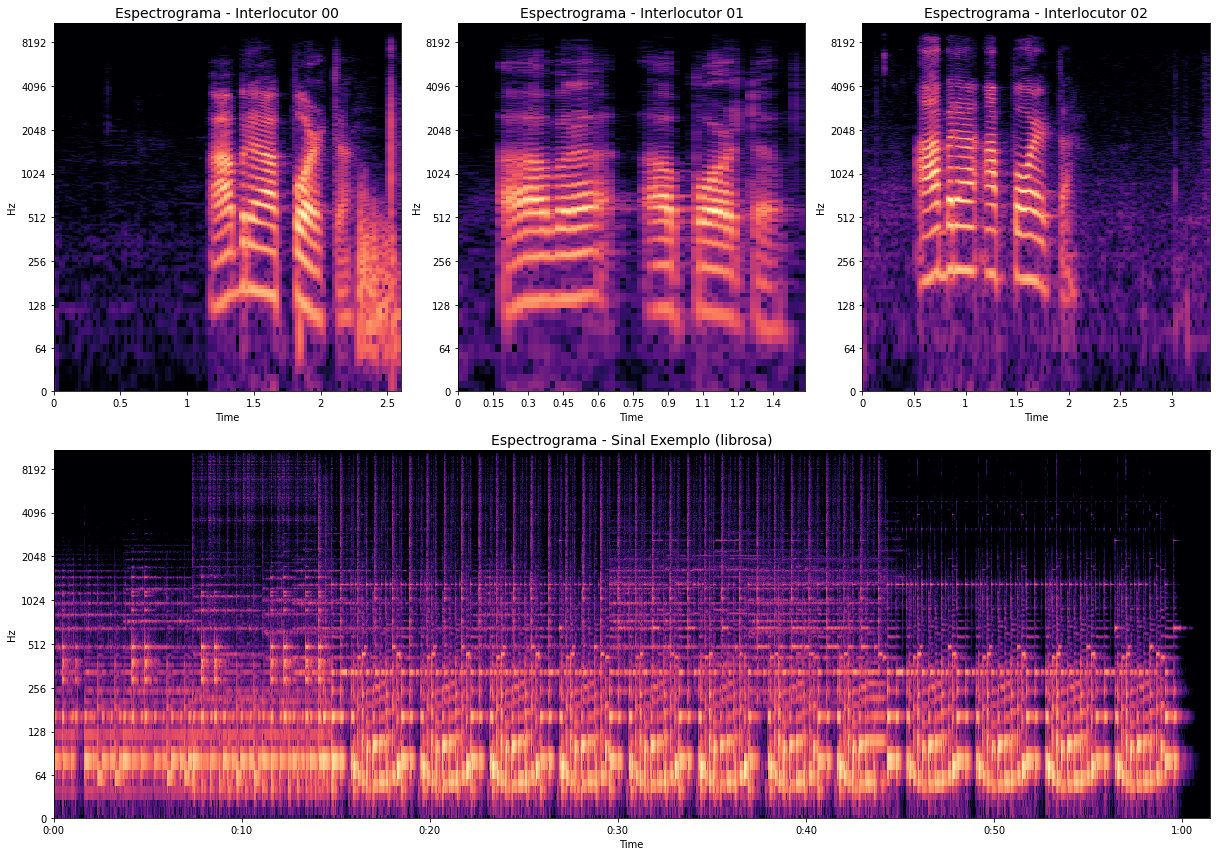

In [19]:
# Definindo figura de plotagem e eixos
fig = plt.figure(constrained_layout=True, figsize=(17, 12))
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, :])

axis = [ax1, ax2, ax3, ax4]
i = 0

# Iterando sobre sinais
for y, sr in zip(audios, sample_rates):
    ax = axis[i]
    
    # Calculando transformada e convertendo em dB
    S = librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    
    # Plotando espectrograma
    ld.specshow(data=S_db, sr=sr, cmap='magma', ax=ax, x_axis='time', y_axis='log')
    ax.set_title(f'Espectrograma - Interlocutor 0{i}', size=14)
    
    # Incrementando índices
    i += 1
    
# Alinhando título final
ax4.set_title('Espectrograma - Sinal Exemplo (librosa)', size=14)

plt.tight_layout()

Observando os espectros acima, é possível observar que:

* O eixo x representa o tempo
* Em y temos a frequência em Hz
* Nas cores, a magnitude da amplitude em dB

In [44]:
print(f'Dimensões de y_i1: {y_i1.shape}')
print(f'Amostra de y_i1: \n{y_i1[:3]}')

# Calculando FFT usando Numpy
y1_fft = np.fft.fft(y_i1)
print(f'\nDimensões de y1_fft: {y1_fft.shape}')
print(f'Amostra de y1_fft: \n{y1_fft[:3]}')

# Calculando parte absoluta (magnitude)
y1_abs_fft = np.abs(y1_fft)
print(f'\nAmostra de y1_abs_fft: \n{y1_abs_fft[:3]}')

# Retornando espectro de frequências (com M = N)
freqs = np.linspace(0, sr, len(y_i1))
print(f'\nDimensão de freqs: {freqs.shape}')
print(f'Amostra de freqs: \n{freqs[:3]}')

Dimensões de y_i1: (56889,)
Amostra de y_i1: 
[-1.17150755e-07  1.63246639e-07 -2.13971731e-07]

Dimensões de y1_fft: (56889,)
Amostra de y1_fft: 
[ 2.5738551 +0.j        -0.27662823+0.6901511j  1.87256122-1.4424726j]

Amostra de y1_abs_fft: 
[2.5738551  0.74352654 2.36372856]

Dimensão de freqs: (56889,)
Amostra de freqs: 
[0.         0.38760371 0.77520743]


In [54]:
f_ratio = .2
freq_bins = int(len(y1_abs_fft) * f_ratio)
freq_bins

11377

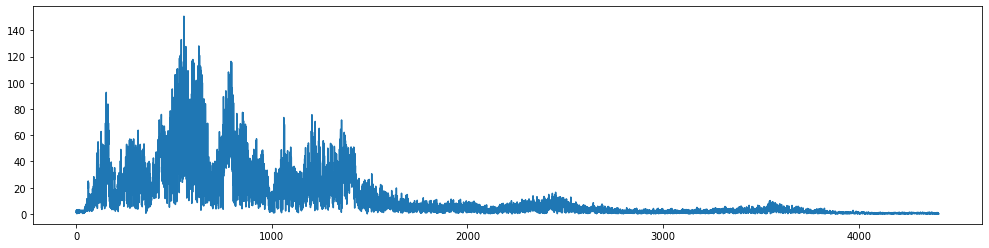

In [55]:
fig, ax = plt.subplots(figsize=(17, 4))
ax.plot(freqs[:freq_bins], y1_abs_fft[:freq_bins])